In [2]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser

In [ ]:
# Parameter Definitions
# Analysis Years
Years = range(2012,2017)

# Project Folders and GDBs
Project_DIR = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO00_OtherStates\NewMexico\3_WorkData\7_NetworkScreening'
Project_GDB = Project_DIR + '\\5.NM_NS_GDB.gdb'
Project_Output = Project_DIR + '\\6.Python_Notebook'

# Roadway and Crash Data
NM_Route = {y:os.path.join(IRISPath,'HWY'+str(y)+'_route.shp') for y in Years}
NM_Table = {y:os.path.join(IRISPath,'HWY'+str(y)+'_table.dbf') for y in Years}
CrashData = {y:os.path.abspath('C:\Users\mr068144\Downloads\IL Crash Data\\' + str(y) + '\\AggregateFiles' +str(y)+ '.mdb'
                          '\\CrashExtract_' + str(y) + '_GIS') for y in Years}
Fields = ['AADT']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

In [1]:
%%javascript
IPython.notebook.kernel.execute('nb_name = ' + '"' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [ ]:
# Copy Current Notebook to Project Folder
curent_nb = os.path.join(os.getcwd(), nb_name)
copyfile(curent_nb,os.path.join(Project_Output,nb_name))
print('{}\ncopied to:\n {}'.format(curent_nb,os.path.join(Project_Output,nb_name)))

In [ ]:
# Summary Stats of Crash Data


Highest risk—5 percent of highway system length, shown in black.
• Medium-high risk—10 percent of highway system length, shown in red.
• Medium risk—20 percent of highway system length, shown in yellow.
• Medium-low risk—25 percent of highway system length, shown in light green.
• Lowest risk—40 percent of highway system length, shown in dark green.

In [27]:
def PlotSWRes(df,CL):
    plt.figure(figsize=(10,6))
    plt.gca().set_xlim([min(df.BMP),max(df.EMP)])
    plt.gca().set_ylim([min(df.CrashFreq)-1,max(df.CrashFreq)+1])
    plt.axhline(y=0, color='r', linestyle='-',label = 'Route (Linear Referencing)')
    plt.plot(CL,[0 for i in CL],'o',color = 'red',label='Crash Mileposts')
    plt.plot(df.Cen,df.CrashFreq,'-|',color='green',label = 'Sliding Window Residuals')
    Flag = False
    for i,r in df.iterrows():
        if r.Chosen:
            if not Flag:
                plt.plot([r.BMP,r.EMP],[r.CrashFreq,r.CrashFreq],'-|',color='b',label='High Windows')
                Flag = True
            else:
                plt.plot([r.BMP,r.EMP],[r.CrashFreq,r.CrashFreq],'-|',color='b')
            plt.plot([r.BMP,r.EMP],[0,0],'-|',color='b')
            plt.text((r.BMP+r.EMP)/2.0, -0.2, r.CrashFreq, fontsize=12,color='b')
    plt.grid()
    plt.xlabel('Milepost')
    plt.ylabel('Excess Expected Average Crash Frequency with EB Adjustment')
    plt.legend(loc='upper right')
    #L=plt.legend()
    #L.get_texts()[0].set_text('make it short')
    plt.savefig('slidingwindow.png',transparent=True)
    plt.show()
def SlidingWindow(BMP,EMP,CL,Len,Inc):
    n = 0
    if EMP-BMP>Len:
        n = int(float(EMP-BMP-Len)/Inc)
    BMPList = [BMP + i*Inc for i in range(0,n+1)]
    df = pd.DataFrame(columns = ['BMP','Cen','EMP','CrashFreq','CrashIDs'])
    for i,bmp in enumerate(BMPList):
        if bmp+Len <= EMP:
            df.loc[i] = [bmp,bmp+Len/2.0,bmp+Len,len([c for c in CL if c>=bmp and c<bmp+Len]),';'.join([str(j) for j,c in enumerate(CL) if c>=bmp and c<bmp+Len])]
        else:
            df.loc[i] = [bmp,(EMP-bmp)/2.0,EMP,len([c for c in CL if c>=bmp and c<bmp+Len]),';'.join([str(j) for j,c in enumerate(CL) if c>=bmp and c<bmp+Len])]
    ccdf = FindSegs(df)
    chosen = []
    for i,r in df.iterrows():
        flag = False
        for j,k in ccdf.iterrows():
            if k.BMP==r.BMP and k.EMP==r.EMP:
                flag = True
                break
        chosen.append(flag)
    df['Chosen'] = chosen
    return(df)
def ConvertIDtoFreq(s):
    if s == '':
        return 0
    else:
        return len(s.split(';'))
def FindSegs(df):
    def OverlapControl(Seg,SegList):
        for seg in SegList:
            if (Seg[0]>= seg[0] and Seg[0]<= seg[1]) or (Seg[1]>= seg[0] and Seg[1]<= seg[1]):
                return False
        return True
    vcdf = pd.DataFrame(df.CrashFreq.value_counts()).sort_index(ascending=False)
    cidf = pd.DataFrame(df.CrashIDs.value_counts()).sort_index()
    cidf['CrashFreq'] = [ConvertIDtoFreq(s) for s in cidf.index]
    cidf['ID'] = cidf.index
    cidf=cidf.sort_values(by=['CrashFreq','CrashIDs'],ascending=False)
    bmp = []
    emp = []
    for i,r in cidf.iterrows():
        sdf = df[df.CrashIDs == r.name].copy()
        cl = [CL[int(j)] for j in r.name.split(';') if r.name!='']
        diff = []
        for j,k in sdf.iterrows():
            b = 0;e = 0
            if len(cl)>0:
                b = min(cl)-k.BMP 
                e = k.EMP-max(cl)
            diff.append(abs(b-e))
        sdf['Diff'] = diff
        sdf = sdf.sort_values('Diff')
        bmp.append(sdf.iloc[0]['BMP'])
        emp.append(sdf.iloc[0]['EMP'])
        #display(sdf)
        #print(cl)
    cidf['BMP'] = bmp
    cidf['EMP'] = emp
    chosenSegs = []
    res = []
    for i,r in cidf.iterrows():
        flag = OverlapControl([r.BMP,r.EMP],chosenSegs)
        if flag:
            chosenSegs.append([r.BMP,r.EMP])
        res.append(flag)
    cidf['Chosen'] = res
    ccdf = cidf[cidf.Chosen == True].copy()
    return(ccdf)
        

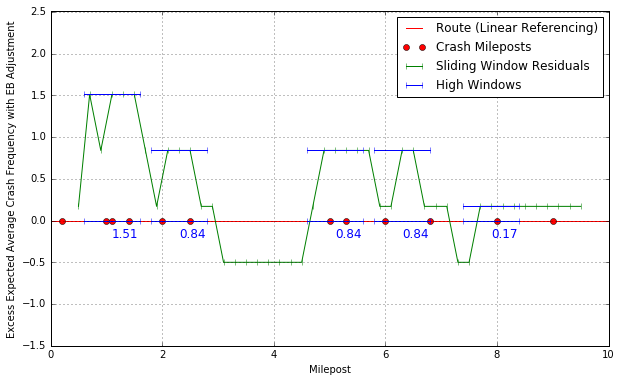

,BMP,Cen,EMP,CrashFreq,CrashIDs,Chosen,Expected,Predicted
3,0.6,1.1,1.6,1.51,1;2;3,True,2.01,0.5
9,1.8,2.3,2.8,0.84,4;5,True,1.34,0.5
23,4.6,5.1,5.6,0.84,6;7,True,1.34,0.5
29,5.8,6.3,6.8,0.84,8;9,True,1.34,0.5
37,7.4,7.9,8.4,0.17,10,True,0.67,0.5


In [28]:
CL = [0.2,1,1.1,1.4,2,2.5,5,5.3,6,6.8,8,9]
df = SlidingWindow(BMP=0,EMP=10,CL = CL,Len=1,Inc=0.2)
df['Expected'] = df['CrashFreq'] * 0.67
df['Predicted'] = 0.5
df['CrashFreq'] = df['Expected'] - df['Predicted']
PlotSWRes(df,CL)
#df.to_html("deleteme.html")
#url = "http://localhost:8888/tree/Downloads/NM/deleteme.html"
#webbrowser.open(url,new=2)
display(df[df.Chosen])